# train

In [1]:
import yaml
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

<ipython-input-1-1499ab5789c7>:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
os.makedirs(OUTPUT_ROOT, exist_ok=True)

## load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# pytorch
import torch
from torch import optim, nn
from torch.utils.tensorboard import SummaryWriter
import timm
import torch_optimizer
#from torchvision.models import wide_resnet50_2, resnet18
#from torchsummary import summary

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})

# original library
import common as com
import pytorch_modeler as modeler
#from pytorch_model import ResNet38 as Model
#from pytorch_utils import filtered_load_model
#import models

import librosa
import IPython
import librosa.display

In [4]:
#model = timm.create_model('efficientnet_b1', pretrained=True)
#3, 320, 320
#name: (channel_multiplier, depth_multiplier, resolution, dropout_rate)
#(1.4, 1.8, 380, 0.4)

In [5]:
#model.blocks[0][0]

## load config and set logger

In [6]:
log_folder = config['IO_OPTION']['OUTPUT_ROOT']+'/{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_folder, '00_train.py')

## Setting

In [7]:
# Setting seed
modeler.set_seed(42)

In [8]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_dir = INPUT_ROOT + "/dev_data"
add_dev_dir = INPUT_ROOT + "/add_dev_data"
# machine type
machine_types = os.listdir(dev_dir)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
OUT_FEATURE_DIR = OUTPUT_ROOT + '/extraction_features'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(OUT_FEATURE_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/HDD1TB/research/DCASE_experiments/domain_adaptation/exp4/PANDA/config.yaml'

In [9]:
torch.cuda.is_available()

True

## make path list

- __train_paths__ ([dict]): Each Machine Type
    - __ToyCar__ ([dict]): Each dataset
        - train ([list]) : paths
        - valid_source ([list]) : paths
        - valid_target ([list]) :paths
    - __ToyTrain__ ([dict]): Each dataset
        - train ([list]) : paths
        - valid_source ([list]) : paths
        - valid_target ([list]) : paths
    - ...

In [10]:
dev_paths = {}

for machine_type in machine_types:
    # dev train
    dev_train_paths = [f"{dev_dir}/{machine_type}/train/" + file for file in os.listdir(f"{dev_dir}/{machine_type}/train")]
    dev_train_paths = sorted(dev_train_paths)
    
    print(f'Machine {machine_type}', end=',')
    print(f'dev_train_size : {len(dev_train_paths)}', end=', ')
    dev_train_source_paths = [path for path in dev_train_paths if 'source' in path]
    print(f'source_size : {len(dev_train_source_paths)}', end=', ')
    dev_train_target_paths = [path for path in dev_train_paths if 'target' in path]
    print(f'target_size : {len(dev_train_target_paths)}', end=', ')
    # source mode
    dev_train_paths = dev_train_source_paths + dev_train_target_paths
    
    # add_dev train
    add_dev_paths = [f"{add_dev_dir}/{machine_type}/train/" + file for file in os.listdir(f"{add_dev_dir}/{machine_type}/train")]
    add_dev_paths = sorted(add_dev_paths)
    print(f'adddev_train_size : {len(dev_train_paths)}', end=', ')
    add_dev_source_paths = [path for path in add_dev_paths if 'source' in path]
    print(f'source_size : {len(add_dev_source_paths)}', end=', ')
    add_dev_target_paths = [path for path in add_dev_paths if 'target' in path]
    print(f'target_size : {len(add_dev_target_paths)}')
    # source mode
    add_dev_paths = add_dev_source_paths + add_dev_target_paths
    print('==============================================================')
    
    # dev_source valid
    dev_source_paths = [f"{dev_dir}/{machine_type}/source_test/" + file for file in os.listdir(f"{dev_dir}/{machine_type}/source_test")]
    dev_source_paths = sorted(dev_source_paths)
    
    # dev_target valid
    dev_target_paths = [f"{dev_dir}/{machine_type}/target_test/" + file for file in os.listdir(f"{dev_dir}/{machine_type}/target_test")]
    dev_target_paths = sorted(dev_target_paths)
    
    # bundle
    dev_paths[machine_type] = {}
    dev_paths[machine_type]['train'] = dev_train_paths + add_dev_paths
    dev_paths[machine_type]['valid_source'] = dev_source_paths
    dev_paths[machine_type]['valid_target'] = dev_target_paths

Machine fan,dev_train_size : 3009, source_size : 3000, target_size : 9, adddev_train_size : 3009, source_size : 3000, target_size : 9
Machine gearbox,dev_train_size : 3026, source_size : 3017, target_size : 9, adddev_train_size : 3026, source_size : 3105, target_size : 9
Machine pump,dev_train_size : 3009, source_size : 3000, target_size : 9, adddev_train_size : 3009, source_size : 3000, target_size : 9
Machine slider,dev_train_size : 3009, source_size : 3000, target_size : 9, adddev_train_size : 3009, source_size : 3000, target_size : 9
Machine ToyCar,dev_train_size : 3009, source_size : 3000, target_size : 9, adddev_train_size : 3009, source_size : 3000, target_size : 9
Machine ToyTrain,dev_train_size : 3009, source_size : 3000, target_size : 9, adddev_train_size : 3009, source_size : 3000, target_size : 9
Machine valve,dev_train_size : 3009, source_size : 3000, target_size : 9, adddev_train_size : 3009, source_size : 3000, target_size : 9


In [11]:
machine_types

['fan', 'gearbox', 'pump', 'slider', 'ToyCar', 'ToyTrain', 'valve']

In [12]:
machine_types

['fan', 'gearbox', 'pump', 'slider', 'ToyCar', 'ToyTrain', 'valve']

In [13]:
feat = pd.read_pickle(f'{OUT_FEATURE_DIR}/{machine_types[0]}_features.pkl')

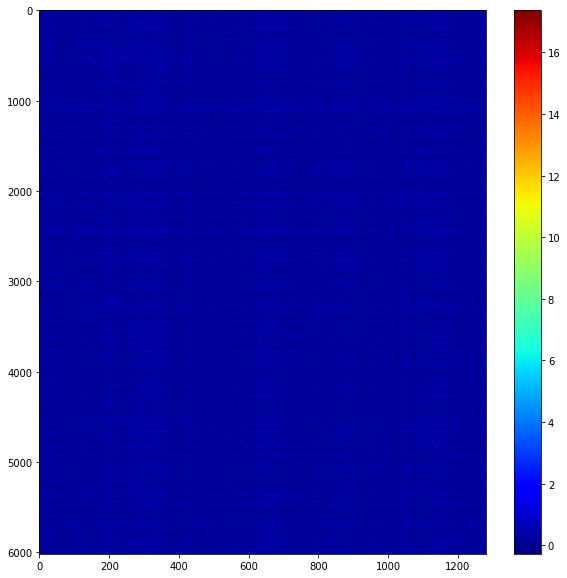

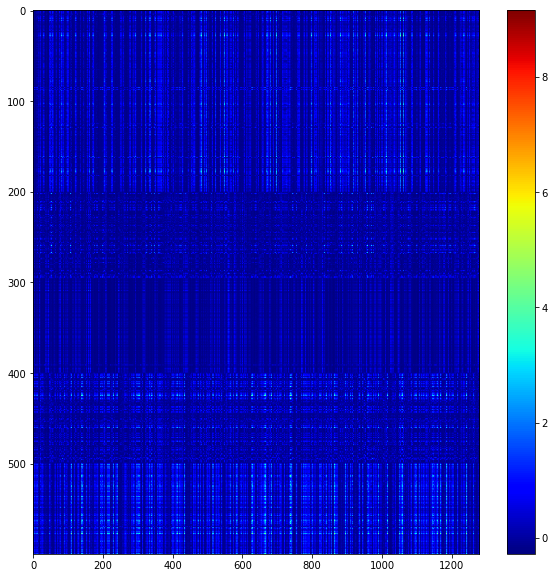

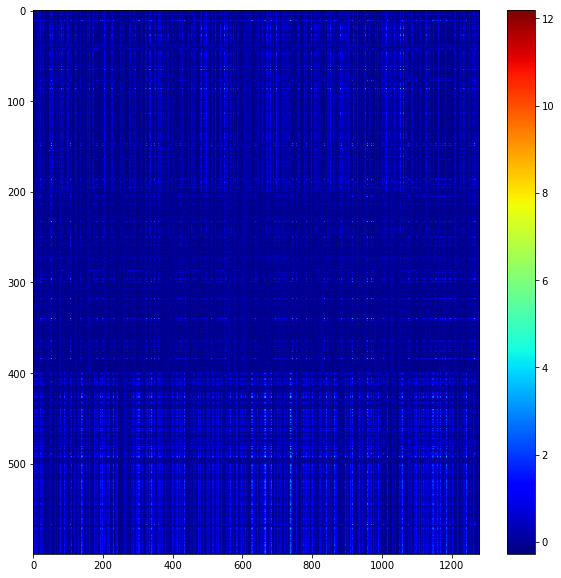

In [14]:
for phase in ['train','val_src', 'val_tgt']:
    plt.figure(figsize=(10,10))
    plt.imshow(feat[phase]['feature'].astype(float), aspect='auto', cmap='jet')
    plt.colorbar()
    plt.show()

# UMAP

In [15]:
from umap import UMAP

In [16]:
output_dicts = pd.read_pickle(f'{OUT_FEATURE_DIR}/{machine_types[0]}_features.pkl')

In [17]:
output_dicts

{'train': {'loss': 42.38132154941559,
  'feature': array([[-0.19308959, -0.10837457, -0.08170553, ...,  0.7265255 ,
          -0.021237  , -0.09424137],
         [-0.19938199, -0.16136578, -0.12639903, ..., -0.13330312,
          -0.23840837, -0.16908768],
         [-0.15967721,  0.37777486,  1.0757232 , ..., -0.20139332,
           0.7278027 , -0.17053671],
         ...,
         [ 0.4580434 , -0.18145473, -0.23062451, ...,  0.66912884,
          -0.12463897,  0.76309645],
         [-0.18240277, -0.17555575, -0.16206275, ..., -0.15683568,
          -0.16311766, -0.17281507],
         [-0.12930937, -0.10671463, -0.06785139, ...,  2.1648936 ,
          -0.08746778, -0.03265346]], dtype=float32),
  'label': array([0, 0, 0, ..., 0, 0, 0]),
  'section_label': array([2, 1, 5, ..., 3, 1, 2]),
  'domain_label': array([0, 0, 0, ..., 0, 0, 0]),
  'wav_name': ['/media/hiroki/HDD1TB/research/dcase2021_task2/datasets/dev_data/fan/train/section_02_source_train_normal_0263_strenght_1_ambient.wav',
 

# train

for machine_type in machine_types:
    output_dicts = pd.read_pickle(f'{OUT_FEATURE_DIR}/{machine_type}_features.pkl')
    # umap
    model = UMAP(random_state=42)
    embedding_var = model.fit_transform(output_dicts['train']['feature'])
    # 結果を二次元でプロットする
    fig = plt.figure(figsize=(10,10))
    secs = com.get_section_types(output_dicts['train']['wav_name'])
    label = output_dicts['train']['label']
    embedding_x = embedding_var[:, 0]
    embedding_y = embedding_var[:, 1]
    for sec in np.unique(secs):
        plt.scatter(embedding_x[secs == sec],
                    embedding_y[secs == sec],
                    label=f'sec={sec}')

    # グラフを表示する
    loss = output_dicts['train']['loss']
    plt.title(f'{machine_type}, loss = {loss}')
    plt.grid()
    plt.legend()
    plt.show()
    fig.savefig(f'./img/{machine_type}_train_embedding.png')

# train shift

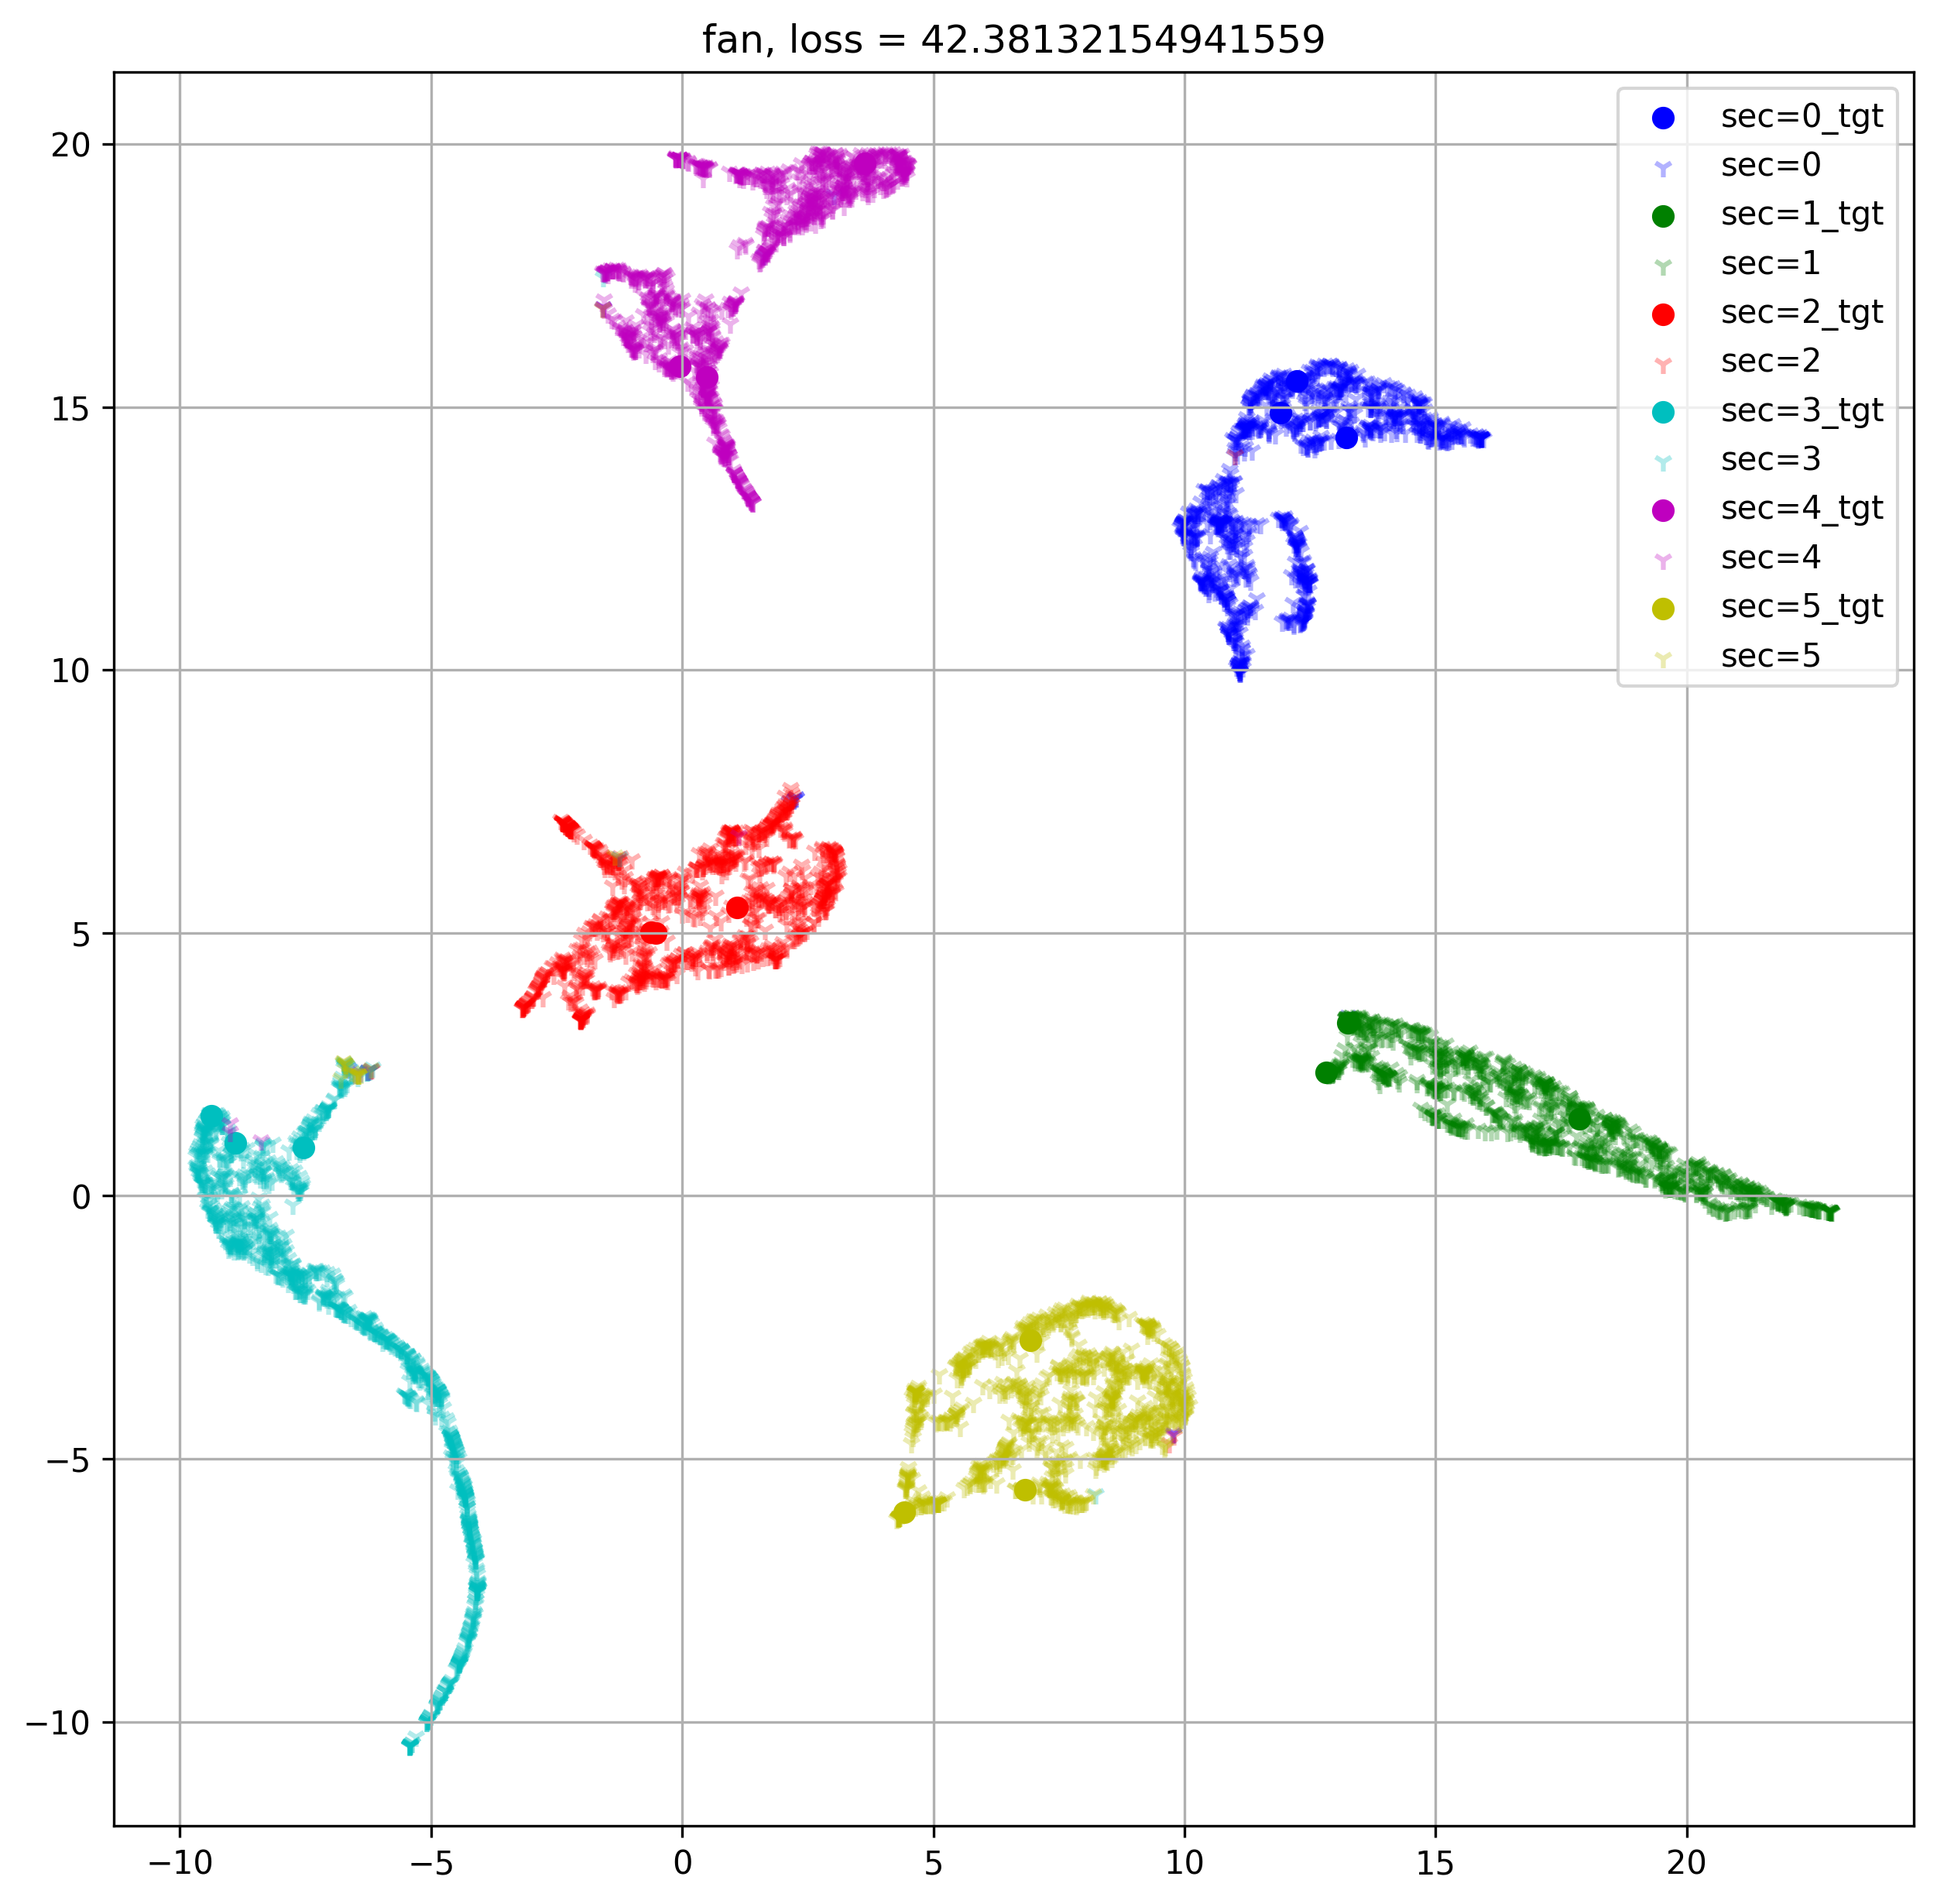

FileNotFoundError: [Errno 2] No such file or directory: './img/fan_train_shift_embedding.png'

In [18]:
colors = ['b','g','r','c','m','y']
for machine_type in machine_types:
    output_dicts = pd.read_pickle(f'{OUT_FEATURE_DIR}/{machine_type}_features.pkl')
    # umap
    model = UMAP(random_state=42)
    embedding_var = model.fit_transform(output_dicts['train']['feature'])
    # 結果を二次元でプロットする
    fig = plt.figure(figsize=(10,10), dpi=300)
    secs = com.get_section_types(output_dicts['train']['wav_name'])
    # tgtのindexを取得
    tgt_idx = np.where(output_dicts['train']['domain_label'] == 1)[0]
    label = output_dicts['train']['label']
    embedding_x = embedding_var[:, 0]
    embedding_y = embedding_var[:, 1]
    
    for sec in np.unique(secs):
        # secのindexを抽出
        sec_idx = np.where(secs == sec)[0]
        # 積集合 (tgtかつhoge section)
        sec_tgt_idx = list(set(tgt_idx) & set(sec_idx))
        # tgt
        plt.scatter(embedding_x[sec_tgt_idx],
                    embedding_y[sec_tgt_idx],
                    label=f'sec={sec}_tgt',
                    c=colors[sec])
        # src
        # 差集合
        sec_src_idx = list(set(sec_idx) - set(sec_tgt_idx))
        plt.scatter(embedding_x[sec_src_idx],
                    embedding_y[sec_src_idx],
                    label=f'sec={sec}',
                    c=colors[sec],
                    alpha=0.3,
                    marker='1')#tri_down
        
    # グラフを表示する
    loss = output_dicts['train']['loss']
    plt.title(f'{machine_type}, loss = {loss}')
    plt.grid()
    plt.legend()
    plt.show()
    fig.savefig(f'./img/{machine_type}_train_shift_embedding.png')

# valid_src

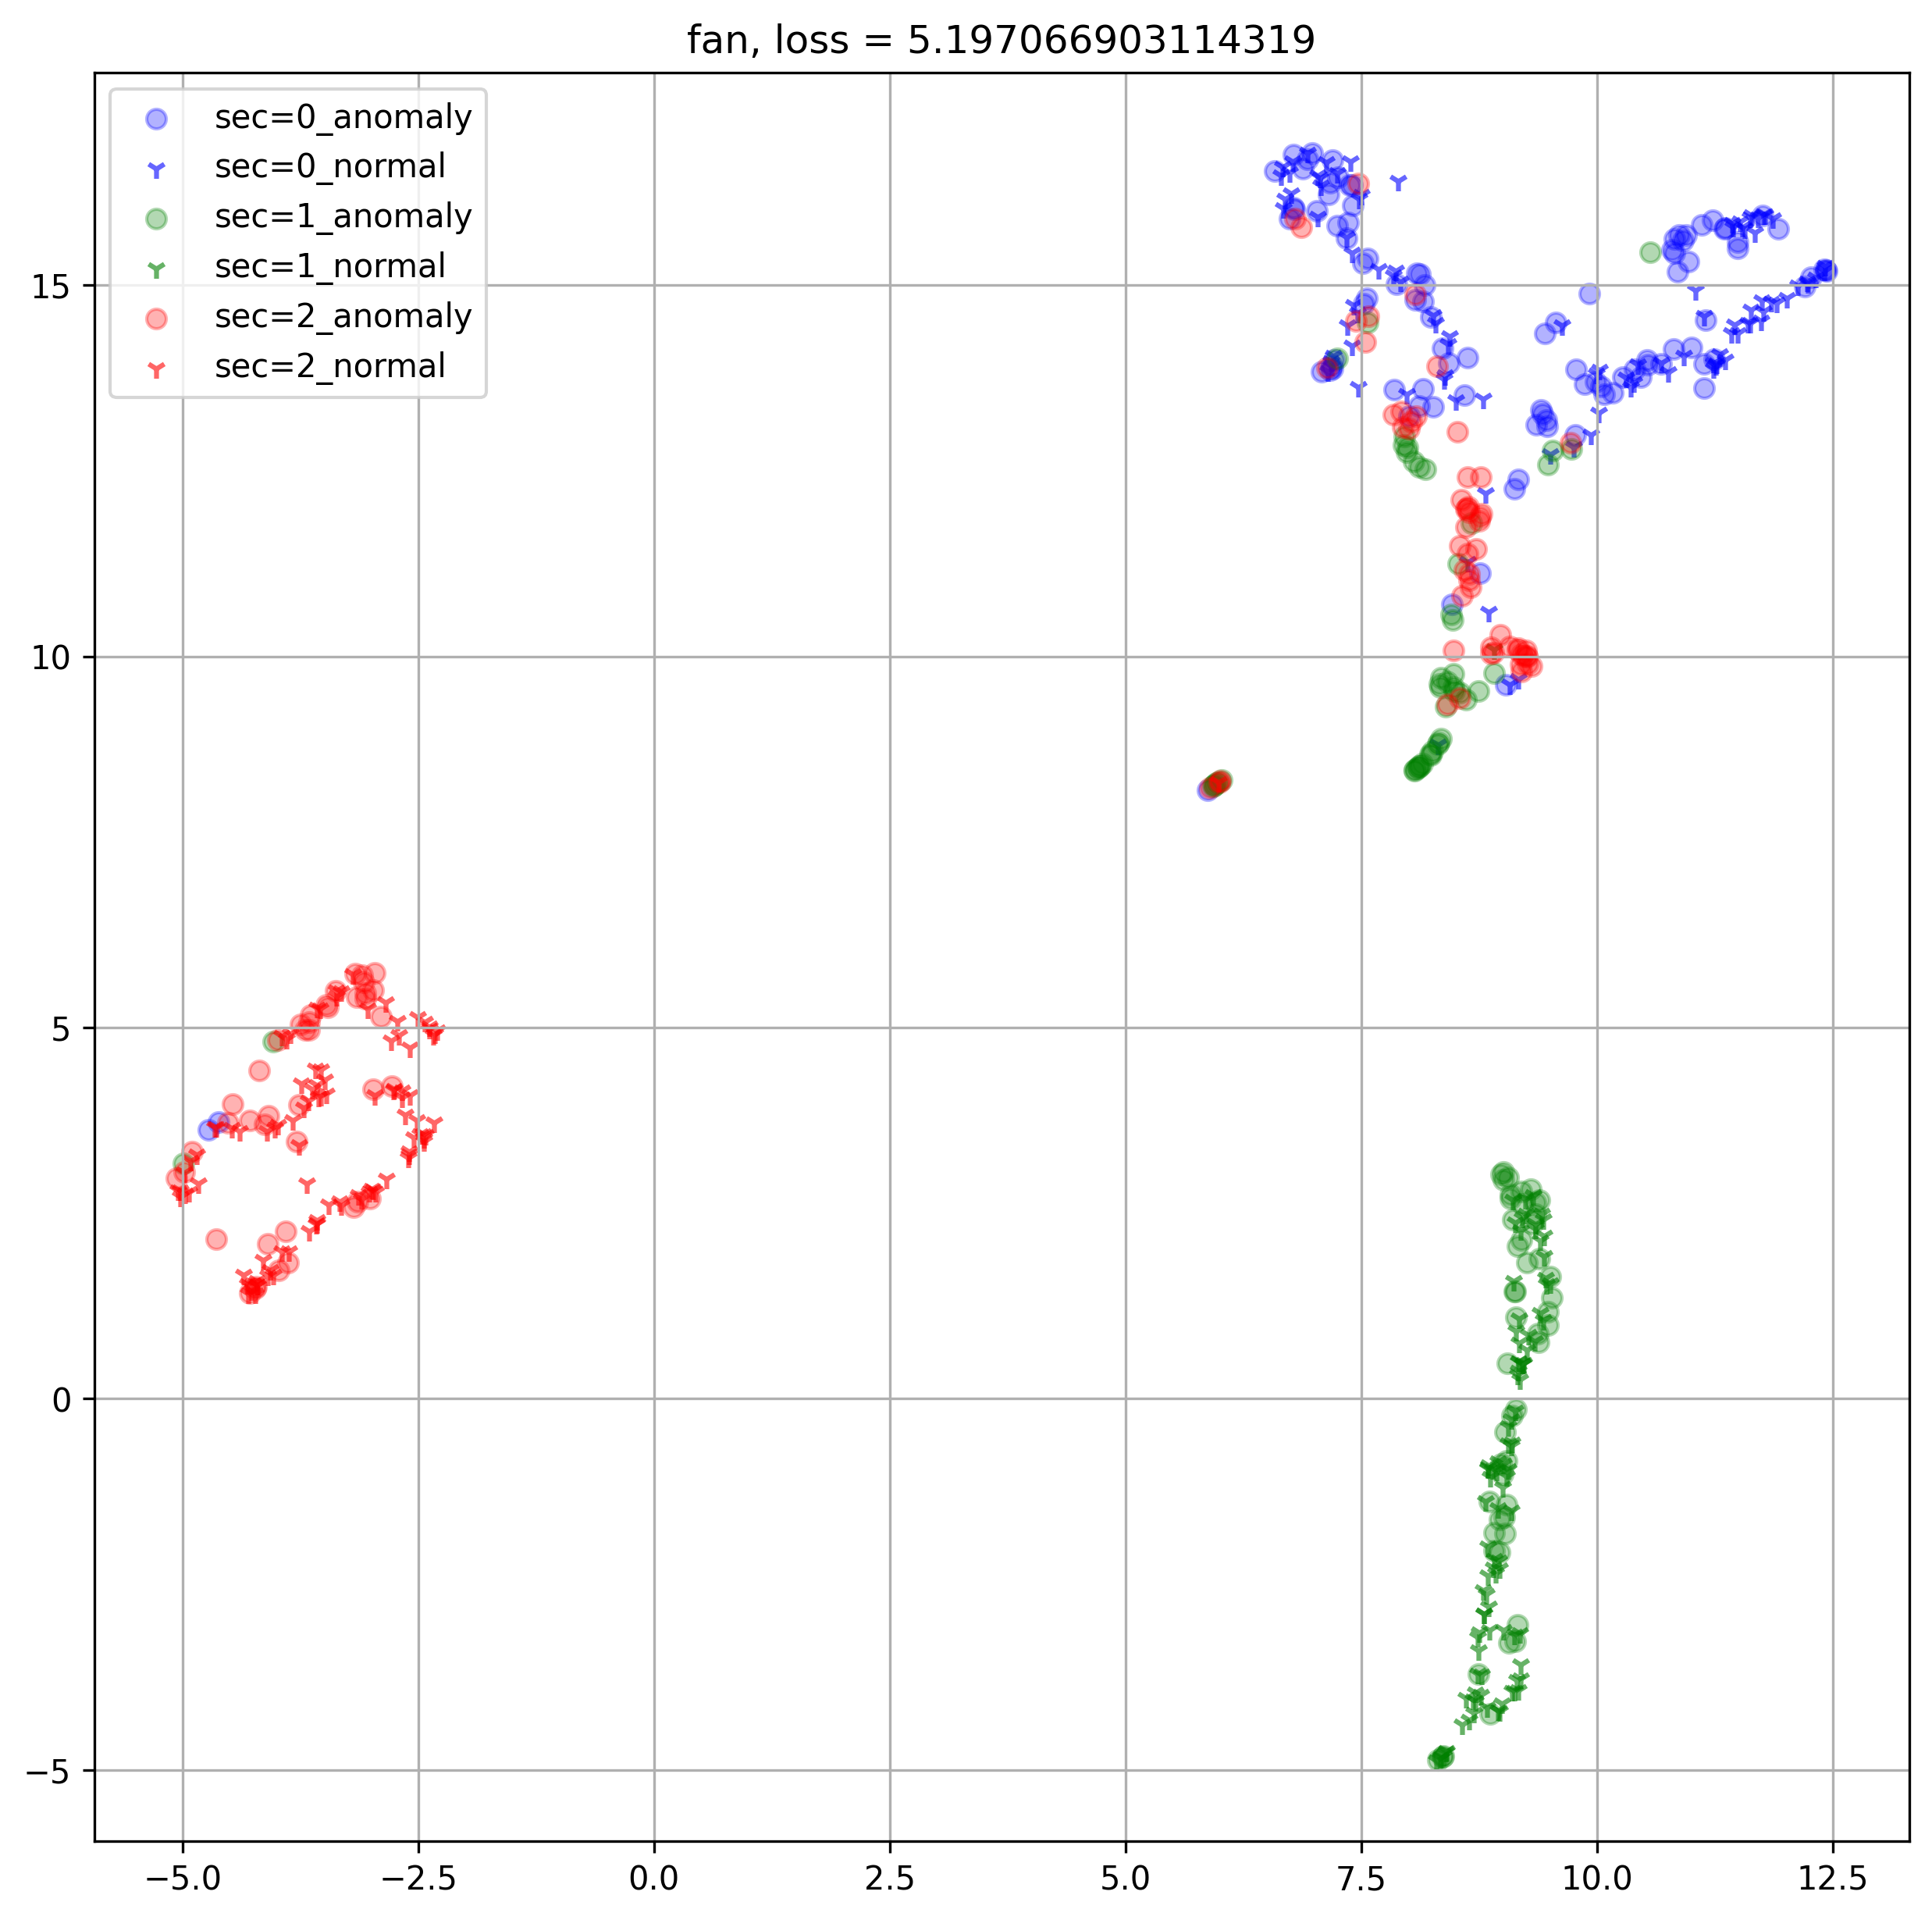

FileNotFoundError: [Errno 2] No such file or directory: './img/fan_valsrc_DeepRepresentation.png'

In [19]:
colors = ['b','g','r','c','m','y']
for machine_type in machine_types:
    output_dicts = pd.read_pickle(f'{OUT_FEATURE_DIR}/{machine_type}_features.pkl')
    # umap
    model = UMAP(random_state=42)
    embedding_var = model.fit_transform(output_dicts['val_src']['feature'])
    # 結果を二次元でプロットする
    fig = plt.figure(figsize=(10,10), dpi=300)
    secs = com.get_section_types(output_dicts['val_src']['wav_name'])
    # tgtのindexを取得
    tgt_idx = np.where(output_dicts['val_src']['domain_label'] == 1)[0]
    # anomalyのindexを取得
    label = output_dicts['val_src']['label']
    ano_idx = np.where(label == 1)[0]
    embedding_x = embedding_var[:, 0]
    embedding_y = embedding_var[:, 1]
    
    for sec in np.unique(secs):
        # secのindexを抽出
        sec_idx = np.where(secs == sec)[0]
        # 積集合 (tgtかつhoge section)
        sec_ano_idx = list(set(ano_idx) & set(sec_idx))
        # anomaly
        plt.scatter(embedding_x[sec_ano_idx],
                    embedding_y[sec_ano_idx],
                    label=f'sec={sec}_anomaly',
                    alpha=0.3,
                    c=colors[sec])
        # src
        # 差集合 (normal)
        sec_normal_idx = list(set(sec_idx) - set(sec_ano_idx))
        plt.scatter(embedding_x[sec_normal_idx],
                    embedding_y[sec_normal_idx],
                    label=f'sec={sec}_normal',
                    c=colors[sec],
                    alpha=0.6,
                    marker='1')#tri_down
        
    # グラフを表示する
    loss = output_dicts['val_src']['loss']
    plt.title(f'{machine_type}, loss = {loss}')
    plt.grid()
    plt.legend()
    plt.show()
    fig.savefig(f'./img/{machine_type}_valsrc_DeepRepresentation.png')

# valid_tgt

In [ ]:
colors = ['b','g','r','c','m','y']
for machine_type in machine_types:
    output_dicts = pd.read_pickle(f'{OUT_FEATURE_DIR}/{machine_type}_features.pkl')
    # umap
    model = UMAP(random_state=42)
    embedding_var = model.fit_transform(output_dicts['val_tgt']['feature'])
    # 結果を二次元でプロットする
    fig = plt.figure(figsize=(10,10), dpi=300)
    secs = com.get_section_types(output_dicts['val_tgt']['wav_name'])
    # tgtのindexを取得
    tgt_idx = np.where(output_dicts['val_tgt']['domain_label'] == 1)[0]
    # anomalyのindexを取得
    label = output_dicts['val_tgt']['label']
    ano_idx = np.where(label == 1)[0]
    embedding_x = embedding_var[:, 0]
    embedding_y = embedding_var[:, 1]
    
    for sec in np.unique(secs):
        # secのindexを抽出
        sec_idx = np.where(secs == sec)[0]
        # 積集合 (tgtかつhoge section)
        sec_ano_idx = list(set(ano_idx) & set(sec_idx))
        # anomaly
        plt.scatter(embedding_x[sec_ano_idx],
                    embedding_y[sec_ano_idx],
                    label=f'sec={sec}_anomaly',
                    alpha=0.3,
                    c=colors[sec])
        # src
        # 差集合 (normal)
        sec_normal_idx = list(set(sec_idx) - set(sec_ano_idx))
        plt.scatter(embedding_x[sec_normal_idx],
                    embedding_y[sec_normal_idx],
                    label=f'sec={sec}_normal',
                    c=colors[sec],
                    alpha=0.6,
                    marker='1')#tri_down
        
    # グラフを表示する
    loss = output_dicts['val_tgt']['loss']
    plt.title(f'{machine_type}, loss = {loss}')
    plt.grid()
    plt.legend()
    plt.show()
    fig.savefig(f'./img/{machine_type}_valtgt_DeepRepresentation.png')